# Практическая работа 6 Журавлев А.Д. ББМО-02-23

Подключение библиотек

In [13]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

Загрузка датасета MNIST

In [15]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

Создание простой полносвязной модели

In [17]:
model1 = Sequential([Flatten(input_shape=(28, 28)), Dense(128, activation='relu'), Dense(10, activation='softmax')])
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model1.fit(train_images, train_labels, epochs=5)
test_loss, test_acc = model1.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')
model1.save('mnist_model_1.h5')

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8764 - loss: 0.4364
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9644 - loss: 0.1206
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9758 - loss: 0.0784
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9825 - loss: 0.0592
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9871 - loss: 0.0428
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9685 - loss: 0.1005


Test accuracy on clean images: 0.9739000201225281


Создание свёрточной нейронной сети

In [18]:
model2 = Sequential([Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)), MaxPooling2D((2, 2)), Flatten(), Dense(128, activation='relu'), Dense(10, activation='softmax')])
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.fit(train_images, train_labels, epochs=5)
test_loss, test_acc = model2.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')
model2.save('mnist_model_2.h5')

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9135 - loss: 0.2897
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9851 - loss: 0.0496
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9910 - loss: 0.0298
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9942 - loss: 0.0180
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9964 - loss: 0.0120
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9812 - loss: 0.0618


Test accuracy on clean images: 0.98580002784729


Атака FGSM на простую полносвязную модель

In [19]:
def fgsm_attack(image, epsilon, gradient):
  perturbed_image = image + epsilon * np.sign(gradient)
  perturbed_image = np.clip(perturbed_image, 0, 1)
  return perturbed_image
def generate_adversarial_example(model, images, labels, epsilon):
    adversarial_images = []
    for i in range(len(images)):
      image = tf.convert_to_tensor(images[i].reshape((1, 28, 28, 1)))
      label = labels[i]
      if len(label.shape) > 1 and label.shape[1] > 1:
          label = np.argmax(label),
      label = tf.convert_to_tensor(label)
      with tf.GradientTape() as tape:
          tape.watch(image)
          prediction = model(image)
          loss = tf.keras.losses.categorical_crossentropy(label[None], prediction)
      gradient = tape.gradient(loss, image)
      adversarial_image = fgsm_attack(image.numpy(), epsilon, gradient.numpy())
      adversarial_images.append(np.reshape(adversarial_image, (28, 28, 1)))
    return np.array(adversarial_images)
epsilon = 0.1
adversarial_example = generate_adversarial_example(model1, test_images, test_labels, epsilon)

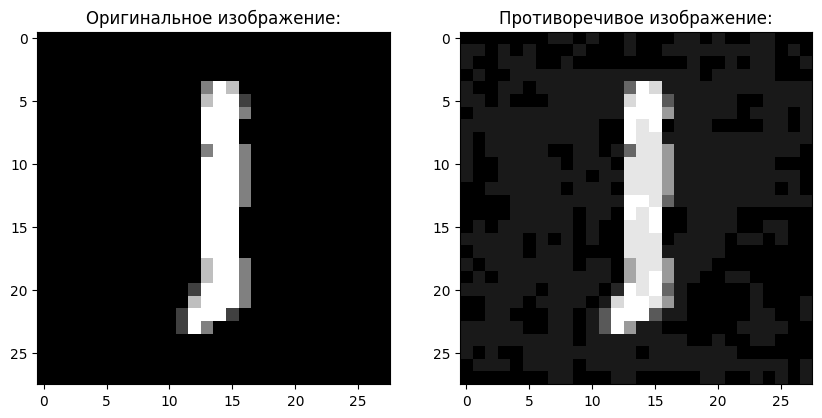

In [20]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение:")
plt.imshow(test_images[14], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение:")
plt.imshow(adversarial_example[14].reshape(28, 28), cmap="gray")
plt.show()

Оценка противоречивых примеров на обеих моделях

In [21]:
adversarial_loss1, adversarial_acc1 = model1.evaluate(adversarial_example.reshape(10000, 28, 28),
test_labels)
adversarial_loss2, adversarial_acc2 = model2.evaluate(adversarial_example.reshape(10000, 28, 28),
test_labels)
print(f'Accuracy of model1 on adversarial examples {adversarial_acc1}')
print(f'Accuracy of model2 on adversarial examples from model1 {adversarial_acc2}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0772 - loss: 7.5716
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9596 - loss: 0.1423
Accuracy of model1 on adversarial examples 0.10329999774694443
Accuracy of model2 on adversarial examples from model1 0.9663000106811523


Атака FGSM на сверточную нейронную сеть

In [22]:
adversarial_example1 = generate_adversarial_example(model2, test_images, test_labels, epsilon)

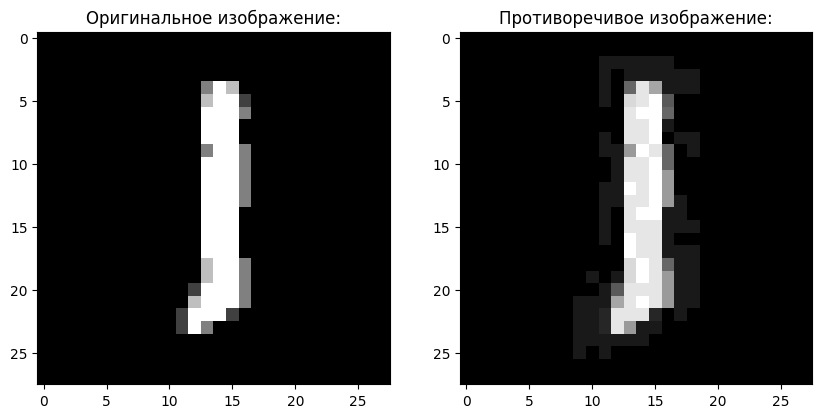

In [23]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение:")
plt.imshow(test_images[14], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение:")
plt.imshow(adversarial_example1[14].reshape(28, 28), cmap="gray")
plt.show()

Оценка противоречивых примеров на обеих моделях

In [24]:
adversarial_loss3, adversarial_acc3 = model1.evaluate(adversarial_example1.reshape(10000, 28, 28),
test_labels)
adversarial_loss4, adversarial_acc4 = model2.evaluate(adversarial_example1.reshape(10000, 28, 28),
test_labels)
print(f'Accuracy of model1 on adversarial examples {adversarial_acc3}')
print(f'Accuracy of model2 on adversarial examples from model1 {adversarial_acc4}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9392 - loss: 0.1866
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7151 - loss: 1.1514
Accuracy of model1 on adversarial examples 0.9480999708175659
Accuracy of model2 on adversarial examples from model1 0.7290999889373779
